In [1]:
exec(open("init_notebook.py").read())

current working dirF:\myProjects\av\junction-art


In [2]:
import numpy as np
import os
import pyodrx 
import math
import dill
from junctions.RoadBuilder import RoadBuilder
from junctions.StandardCurvatures import StandardCurvature
from junctions.StandardCurveTypes import StandardCurveTypes
import extensions


In [3]:
with(open('F:\\myProjects\\av\\junction-art\\output\\_harvestedOrds.dill', 'rb')) as f:
    odrDic = dill.load(f)
    
odrs = odrDic[0.3141592653589793]
odrs2 = [odrs[0], odrs[1]]

In [38]:
class JunctionMerger:

    

    def __init__(self, outputDir, outputPrefix='R3_', lastId=0, minAngle = np.pi / 10, maxAngle = np.pi - .0001):
        """The angle between two connected roads are >= self.minAngle <= self.maxAngle

        Args:
            outputDir ([type]): [description]
            outputPrefix ([type]): [description]
            lastId (int, optional): [description]. Defaults to 0.
            minAngle ([type], optional): [description]. Defaults to np.pi/10.
            maxAngle ([type], optional): [description]. Defaults to np.pi.
        """

        self.destinationPrefix = os.path.join(outputDir, outputPrefix)
        self.minAngle = minAngle
        self.maxAngle = maxAngle
        self.lastId = lastId

        self.roadBuilder = RoadBuilder()

        pass


    def getOutputPath(self, fname):
        return self.destinationPrefix + fname + '.xodr'
    

    def merge2R2L(self, odrs):

        # how do we merge 2 road junctions?
        
        # 1 find connectionRoad in the first, it's predecessor is first road, successor is the second road.

        connectionRoadsFirst = extensions.getConnectionRoads(odrs[0].roads, odrs[0].junctions[0])
        connectionRoadFirst = connectionRoadsFirst[0]
        connectionRoadsSecond = extensions.getConnectionRoads(odrs[1].roads, odrs[1].junctions[0])
        connectionRoadSecond = connectionRoadsFirst[0]

        roadFirstPred = extensions.getRoadFromRoadDic(odrs[0].roads, connectionRoadFirst.predecessor.element_id)
        roadFirstSuc = extensions.getRoadFromRoadDic(odrs[0].roads, connectionRoadFirst.successor.element_id)
        roadSecondPred = extensions.getRoadFromRoadDic(odrs[1].roads, connectionRoadSecond.predecessor.element_id)
        roadSecondSuc = extensions.getRoadFromRoadDic(odrs[1].roads, connectionRoadSecond.successor.element_id)

        print(roadFirstPred)
        print(roadFirstSuc)
        print(roadSecondPred)
        print(roadSecondSuc)

        roads = []
        roads.append(roadFirstPred)
        roads.append(connectionRoadFirst)
        roads.append(roadFirstSuc)
        roads.append(connectionRoadSecond)
        roads.append(roadSecondSuc)

        # fix links for roadFirstSuc, connectionRoadSecond

        roadFirstSuc.successor = None
        roadFirstSuc.add_successor(pyodrx.ElementType.junction, connectionRoadSecond.id)

        connectionRoadSecond.predecessor = None
        connectionRoadSecond.add_predecessor(pyodrx.ElementType.road, roadFirstSuc.id, pyodrx.ContactPoint.start) # interestingly, this becomes the start point after merging.


        # create new junction

        # experiment with connecting more lanes for a single connection road.
        con1 = pyodrx.Connection(roadFirstPred.id, connectionRoadFirst.id, pyodrx.ContactPoint.start)
        con1.add_lanelink(-1,-1)
        
        con2 = pyodrx.Connection(roadFirstSuc.id, connectionRoadSecond.id, pyodrx.ContactPoint.start)
        con2.add_lanelink(-1,-1)

        junction = pyodrx.Junction('junc',1)

        junction.add_connection(con1)
        junction.add_connection(con1)

        # newOdr = self.mergeByRoad(self, commonRoads, ords)

        newOrd = pyodrx.OpenDrive("new road")

        # create the opendrive
        odr = pyodrx.OpenDrive('myroad')
        for r in roads:
            odr.add_road(r)
            
        # odr.create_junction()

        odr.add_junction(junction)
#         odr.adjust_roads_and_lanes()

        print(f"total number of roads added {len(roads)}")

        print(f"total number of roads in odr {len(odr.roads)}")

        
        odr.write_xml(self.getOutputPath("test"))

        return odr

    
    


In [39]:
outputDir= os.path.join(os.getcwd(), 'output')
merger = JunctionMerger(outputDir=outputDir)

In [40]:
newOdr = merger.merge2R2L(odrs2)

total number of roads added 5
total number of roads in odr 2


<?xml version="1.0" ?>
<OpenDRIVE>
	<header date="2020-10-29 12:44:03.869996" east="0.0" name="myroad" north="0.0" revMajor="1" revMinor="5" south="0.0" west="0.0"/>
	<road id="2" junction="-1" length="100">
		<link>
			<predecessor elementId="1" elementType="junction"/>
		</link>
		<planView>
			<geometry hdg="2.8274338437617486" length="100" s="0" x="123.48680495896875" y="148.2900689832599">
				<line/>
			</geometry>
		</planView>
		<lanes>
			<laneSection s="0">
				<left>
					<lane id="1" level="false" type="driving">
						<link/>
						<width a="3" b="0" c="0" d="0" sOffset="0"/>
						<roadMark color="standard" height="0.02" laneChange="none" sOffset="0" type="solid" weight="standard" width="0.2">
							<type name="solid" width="0.2">
								<line length="0" rule="no passing" sOffset="0" space="0" tOffset="0" width="0.2"/>
							</type>
						</roadMark>
					</lane>
				</left>
				<center>
					<lane id="0" level="false" type="driving">
						<link/>
						<width a="3" b

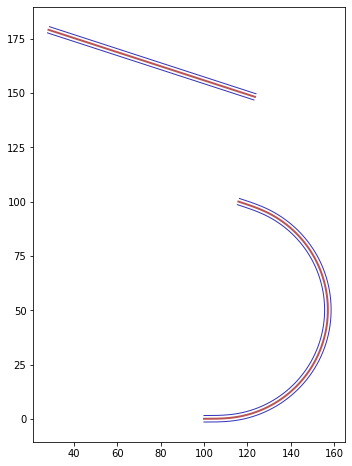

In [26]:

pyodrx.prettyprint(newOdr.get_element())

extensions.view_road(newOdr,os.path.join('..','F:\\myProjects\\av\\esmini'))

In [29]:
newOdr.roads

{'2': <extensions.ExtendedRoad.ExtendedRoad at 0x227859244c8>,
 '1': <extensions.ExtendedRoad.ExtendedRoad at 0x22785918ac8>}